# Groundwater Flow and Contaminant Transport Simulations in a Monte Carlo Framework 

## 1. Import libraries
To run some of the tools offered by Python we need to import libraries.

In [2]:
# Library for scientific computing
import numpy as np
# Libraries for random K-field generator
import hydrogen as hg
# Libraries for flow simulation 
import flopy
# Libraries for contamiant transport simulation 
import yaml
import os
import subprocess

from subprocess import call
# Libraries for postprocessing data and UQ and R Analysis
import RAUQ_function as plib #change the name!!!!
#Library for visualization 
import matplotlib.pyplot as plt

flopy is installed in /Users/jinwooim/opt/anaconda3/lib/python3.7/site-packages/flopy


## 2. Model domain & Grid definition 
<left><img src="images/image1.png" width="300px">

In this section we define how to discretize the model domain of size $L_x \times L_y \times L_z$. $\Delta_C$, $\Delta_R$ and $\Delta_L$ represents the grid cell discretization. Here you also define the coordinates of the contaminant injection area of the target area and observation wells.   

In [27]:
# Model domanin dimentions 
Lx = 170
Ly = 150
Lz = 1

# Grid 
ncol = 170 # number of colum of the grid
nrow = 150 # number of rows of the grid
nlay = 1 # number of layers of the grid 

# Grid cell dimentions 
del_R = Lx/ncol 
del_C = Ly/nrow
del_L = Lz/nlay

# Contaminant source area coordinates, where (0,0) is bottom left corner:
source_xl = 25 
source_xu = 37
source_yl = 65
source_yu = 85

# Target area coordinates, where (0,0) is bottom left corner:
target_xl = 117
target_xu = 129
target_yl = 55
target_yu = 95

# Observations wells coordinates, where (0,0) is bottom left corner:
observation_wells = [ (117, 55), (117, 75), (117, 95) ]



## 3. Hydraulic Conductivity Fields Generation 
### Hydro_gen 
<left><img src="images/image3.png" width="800px">
$\text{Hydro_gen}$ is a random ($Y \equiv \ln (K)$) field generator, where values of $ln(K)$ are spatially-correlated.
    
**WHAT YOU NEED**: 
    
-1 on MAC or LINUX: To run the following kernel you need to include the $\text{Hydro_gen}$ executable (hydrogen_linux or hydrogen_mac, accordingly to the used platform), the hydrogen function (hydrogen.py) and the file where you need to indicate the statistical characteristics shared by the group of generated fields (hydrogen_input.txt) in the folder where this Jupyter Notebook is located. Further details on how to compile the .txt file can be found in the "Hydro_genInfo.pdf" and in the "manual_hydrogen.pdf". 

-2 on WINDOWS: unfortunatly there is no executable file available for the windows platforms, meaning that the user should run the content of the following kernel (including also the "Libraries for random K-field generator" and the "Library for scientific computing") on a MAC or LINUX platform following the instructions above.  

**OUTPUT**: the output of this section is a .npy file (Kfileds_Hydrogen.npy) containing the $K$ values of each of the generated $K$-fields. Each column of the generated file contains the $K$-values of one of one of the filed field.....  (complete with Jinwoo)
If you want to proceed with all the following steps of the simulation on a Windows platform, just copy and past the "Kfileds_Hydrogen.npy" file create with the Linux or Mac platforms in the folder where this Jupyter Notebook is located, comment the entire kernel 3 and proceed with the simulation. 

In [6]:
#Number of simulations of the Monte Carlo analysis
N_mc = 500

#Indicate the operating system that you are using to run this kernel
operating_system = 'mac' # 'mac' or 'linux'

#Generate the random K-fileds usig the previusly imported function
fields = hg.field_generation(N_mc, operating_system)

#Save all the generated fields in a unique file 
np.save('Kfileds_Hydrogen.npy', fields)


generating a field ...
Realization No. 0 done
generating a field ...
Realization No. 1 done
generating a field ...
generating a field ...
generating a field ...
generating a field ...
generating a field ...
Realization No. 2 done
generating a field ...
generating a field ...
generating a field ...
generating a field ...
Realization No. 3 done
generating a field ...
Realization No. 4 done


## 4. Flow Simulations
### FloPy

In this section we are going to simulate flow of groudwater through the just generated aquifers. To do that we use $\text{MODFLOW}$ that is the U.S. Geological Survey modular finite-difference flow model, which is a computer code that solves the groundwater flow equation.  To create, run, and post-process $\text{MODFLOW}$-based models the Python packege $\text{FloPy}$ is used, that we already imported in the library section.

**WHAT YOU NEED**: To run the following kernel you need to include the $\text{MODFLOW}$ executable (mf2005dbl.exe) in the folder where this Jupyter Notebook is located. 

**OUTPUT**: In the folder $\text{tmp}$, a .ftl (flow-transport link) file for each flow simulation is saved. The .ftl file includes flow information necessary to run the contaminat transport simulation.

<left><img src="images/image4.png" width="700px">

Further details on all the packages used here and available in  $\text{MODFLOW}$ and consequesntly implemented in $\text{FloPy}$ are available respectively at https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/ and https://flopy.readthedocs.io/en/3.3.2/index.html. 

In [12]:
#Loop to solve flow simulations on the generated K-filds, for Monte Carlo analysis
for value in range(N_mc): 
    
    # Load K-field generated with Hydro_gen
    y_field = np.load('Kfileds_Hydrogen.npy', allow_pickle=True)[value]

    modflow_exe = 'mf2005dbl'

    # Hydraulic head difference along the x-direction
    delta_h = 1

    # Name of the ftl output file, a different model for each generated K-filed
    outftl_name  = 'model-{}.ftl'.format(value) 

    # Init flopy and Create the output directory
    model_name = "example_Frontiers"

    if not os.path.exists('tmp'):
        os.mkdir('tmp')
    model_ws = "tmp"

    # MODFLOW model definition
    mf = flopy.modflow.Modflow(model_name, model_ws = model_ws, exe_name = modflow_exe)

    # Geometric variables for the DIS package 
    ztop = 0.
    zbot = np.zeros((nlay, nrow, ncol))
    for i in range(nlay):
        zbot[i, :, :] = ztop - delv*(i+1)

    # Add DIS package to the MODFLOW model
    dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr = del_R, delc = del_C,
                               top = ztop, botm = zbot, perlen = 1)

    # Variables for the BAS package
    ibound = np.ones((nlay, nrow, ncol), dtype = np.int32)
    ibound[:, :,  0] = -1
    ibound[:, :, -1] = -1

    strt = np.zeros((nlay, nrow, ncol), dtype = np.float32)
    for i in range(nlay):
        for j in range(nrow):
            strt[i, j, :] = np.linspace(delta_h, 0, num = ncol)
    
    # Add BAS package to the MODFLOW model 
    bas = flopy.modflow.ModflowBas(mf, ibound = ibound, strt = strt)

    # Add LPF package to the MODFLOW model
    lpf = flopy.modflow.ModflowLpf(mf, hk = np.exp(y_field), layvka = 1, vka = 10)

    # Add OC package to the MODFLOW model
    oc = flopy.modflow.ModflowOc(mf)

    # Add PCG package to the MODFLOW model
    pcg = flopy.modflow.ModflowPcg(mf, mxiter = 500, iter1 = 300)

    # Add LMT package to the MODFLOW model
    lmt = flopy.modflow.ModflowLmt(mf, output_file_header = 'extended',
                                       output_file_format = 'formatted',
                                       output_file_name = outftl_name)

    # Write the MODFLOW model input files
    mf.write_input()

    # Run the MODFLOW model
    success, buff = mf.run_model()

    if not success:
        print('FLOW SIMULATION ERROR, SOMETHING WENT WRONG!')

Exception: The program mf2005dbl does not exist or is not executable.

## 5. Contaminant Transport Simulations 
### $\mathbf{PAR^2}$

<left><img src="images/image6.png" width="600px">

In this section we are going to simulate contamiant transport through the just generated aquifers using FloPy outputs. To do that we use $\text{PAR}^2$ that is a Lagrangian solute transport simulator that uses a parallelized Random Walk Particle Tracking (RWPT) method (https://github.com/GerryR/par2).

**WHAT YOU NEED**: To run the following kernel you need to include the $\text{PAR}^2$ executable (par2.exe) and the two .yaml files necessary respectively for definying the model variables (config.yaml) and for implementing the Monte Carlo analysis (config-tmp.yaml), all in the folder where this Jupyter Notebook is located. Additional informations on how to compile and define the variables of the contaminat transport simulation can be found on "PAR2Info.pdf". 

**OUTPUT**: In the folder $\text{output}$, a .csv file (result-\*.csv) for each transport simulation is saved. This file includes the data related to the cumulative breakthrough curves at control planes of interest. For each transport simulation, snaphshot files can be generated at different time steps, indicating the location of the contamiant plume at the give time steps (snap-{}-\*.csv).  


<left><img src="images/image5.png" width="900px">

In [28]:
#Loop to solve transport simulations on the generated K-filds and using the flow simulation results,...
# for Monte Carlo analysis

for value in range(N_mc): 
    
    # PAR2 executable
    par2_exe = 'par2.exe'

    # YAML Configuration file, transport simulation parameters can be modified here
    config_file = 'config.yaml'

    # YAML Configuration file, modification of config.yaml to implement the Monte Carlo Anlysis 
    configout = 'config-tmp.yaml'


    with open(config_file) as fin:
        with open(configout, 'w') as fout:
            for line in fin:
                fout.write(line.replace('{}', str(value)))

        print("EXECUTE PAR2 WITH FIELD {}".format(value))
    
    # Print the parameters in the configuration file
    with open(config_file, 'r') as stream:
        try:
            params = yaml.load(stream)
            print(yaml.dump(params))
        except yaml.YAMLError as exc:
            print(exc)

    # Create the output directory
    if not os.path.exists('output'):
        os.mkdir('output')

    print()

    # Run PAR2
    print('STARTING SIMULATION...')
    call([par2_exe, configout])
    output_csv = 'output'+'/result-{}.csv'.format(value)

EXECUTE PAR2 WITH FIELD 0
grid:
  cell size:
  - 1.0
  - 1.0
  - 1.0
  dimension:
  - 170
  - 150
  - 1
output:
  csv:
    file: output/result-{}.csv
    items:
    - label: cbtx x=117.0
      type: after-x
      x: 117.0
    - label: cbtx x=168.0
      type: after-x
      x: 168.0
    skip: 1
  snapshot:
    file: output/snap-{}-*.csv
    skip: 400
physics:
  longitudinal dispersivity: 0.01
  molecular diffusion: 6.0e-08
  porosity: 0.2
  transverse dispersivity: 0.001
  velocity:
    file: tmp/model-{}.ftl
    type: modflow
simulation:
  dt: 0.05
  particles:
    N: 100000
    start:
      p1:
      - 25
      - 65
      - 0
      p2:
      - 37
      - 85
      - 1
  steps: 100000


STARTING SIMULATION...


PermissionError: [Errno 13] Permission denied: 'par2.exe'

## 6. Uncertainty Quantification \& Risk Analysis 
The Uncertainty Quantification and Risk Analysis proposed in this tutorial has the objective of visualaizing features of the contaminant plume that can be used as indicators for optimized spots of remediation applications. The tools proposed in this section make also the user evaluate metrices of risk, related to the aquifer relaibility, resilience and probability of experiencing thretening concentrations. The interplay between groundwater flow physics and indicators of contaminat residence time at target location can be also investigated. 

**WHAT YOU NEED**: To run the following kernel you need the python file (UQRA_functions.py) including the functions necessary to postprocess the output of the transport simulation and to evalute risk metrices and other variables of interest. 

**OUTPUT**: the output of this kernel is mostly interactive, meaning that you can plot variables realted to chosen realizations and at selected istants of time through the simulation. In addition, you can plot how variables related to risk change in space and time. The data used to generate the plot visualized in this section are automatically saved in a folder called "data_output". 

### 6.1. Features of the evaluated contaminated scenario

In [37]:
# basic info

n_realization = N_mc # choose the realization that you want to include in your analysis
Kg = np.exp(1.60943) # mean K value, the exponential of the
                     # value "mean of the logconductivity field" input in hydrogen_input.txt. 

block_x = del_R
block_y = del_C    
lambda_x = 8         # correlation lengths, as defined in hydrogen_input.txt
lambda_y = 8    
mcl = 0.001          # ratio to c0 (initial concentration)
tstep = np.arange(0,100000+1000,1000)    # as defined in config.yaml, for the transport simulation 
dt = 4               # You can evaluate changing every 4 days of the simulation





plotfn = plib.plotinfo(n_realization, Kg, 
                       Lx, Ly, block_x, block_y, lambda_x, lambda_y, 
                       source_xl, source_xu, source_yl, source_yu, 
                       target_xl, target_xu, target_yl, target_yu,
                       mcl, observation_wells, tstep, dt)

### 6.2. Postprocess Transport Simulations Results
In this kernel, output data from the Transport Simulation kernel are elaborated to create the contaminant concentration fields. This cell has to be run once, to geneate the data. 


In [40]:
# Create the folders where to collect the output of the postprocessing phase and the UQ and R Analysis
if not os.path.exists('data_output'):
    os.mkdir('data_output')
    
if not os.path.exists('data_output/cfields'):
    os.mkdir('data_output/cfields')

if not os.path.exists('data_output/referencepoints'):
    os.mkdir('data_output/referencepoints')


# Postprocess your data

plotfn.cfield_postprocessing()
plotfn.referencepoints_postprocessing()
plotfn.cfield_ensemble_postprocessing()
plotfn.rrfield_postprocessing()
plotfn.eta_postprocessing()
plotfn.maxriskresilience_postprocessing()
plotfn.well_postprocessing()

realization no. 0
processing 0%
processing 50%
processing 100%
realization no. 1
processing 0%
processing 50%
processing 100%
realization no. 2
processing 0%
processing 50%
processing 100%
realization no. 3
processing 0%
processing 50%
processing 100%
realization no. 4
processing 0%
processing 50%
processing 100%


### 6.4. Visulize of locations of maximum concentrations, leading edge of the plume and how the contaminant plume evolves in time of one among the evaluated realizations.


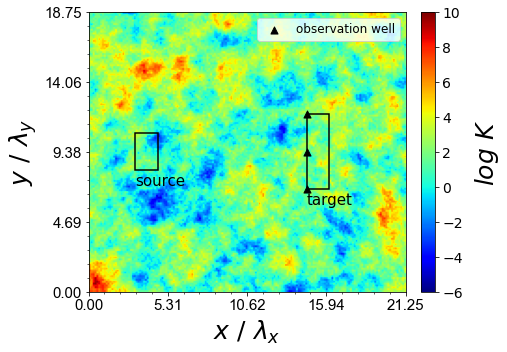

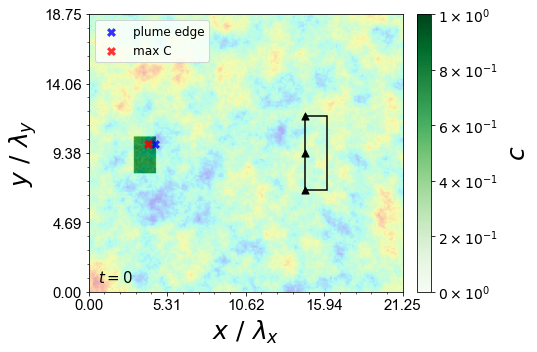

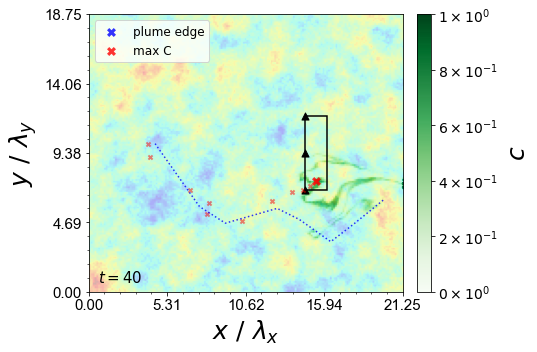

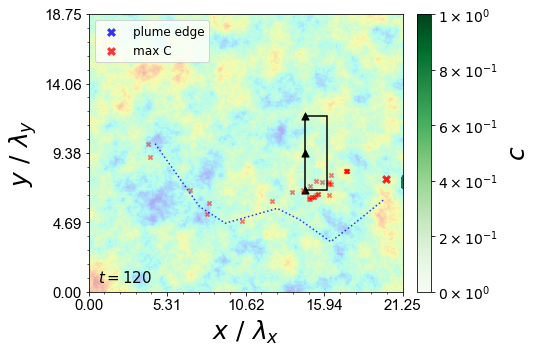

In [41]:
# Choose the realization that you want to visualize
real_n = 0

# Plot the hydraulic conductivity field
filename = f'logkfield_{real_n}'

plotfn.logkfield(filename, real_n)

# Plot the concentration field

filename = f'cfield_{real_n}'
time_index = [ 0, 10, 30 ] # Choose the time steps  
plume_edge = True
max_conc = True

plotfn.cfield(filename, real_n, time_index, plume_edge, max_conc)

### 6.5. Visulize how the contaminant concentration averaged on the whole simulation ensamble  $\langle  C \rangle$ and its variance evolve in time.

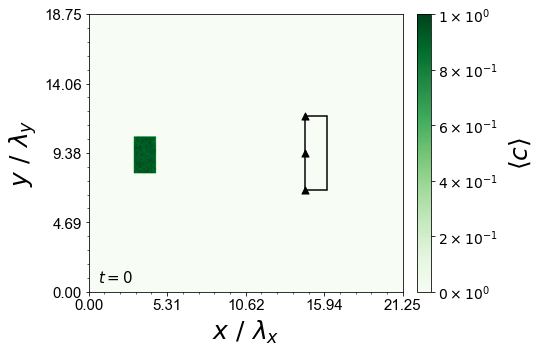

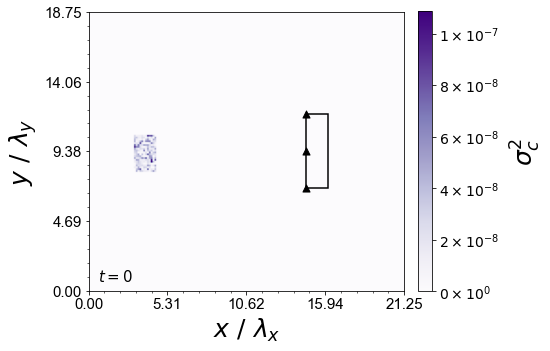

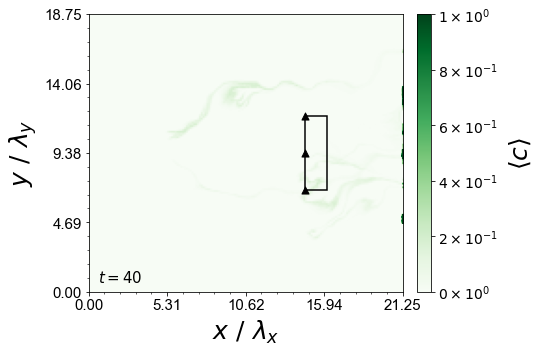

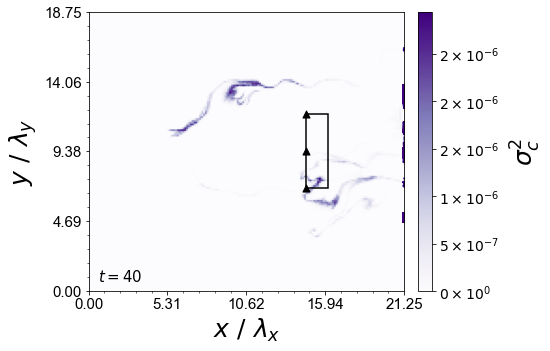

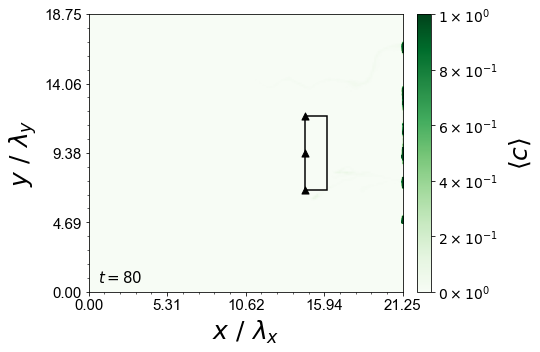

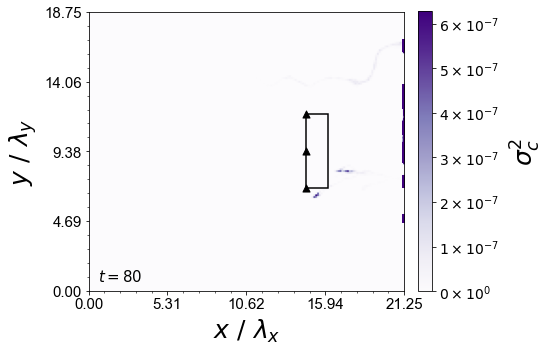

In [42]:
real_n = 'ensemble'
filename = f'cfield_{real_n}'
time_index = [ 0, 10, 20 ] # Choose the time steps 
plume_edge = True
max_conc = True

plotfn.cfield(filename, real_n, time_index, plume_edge, max_conc)

### 6.6. Probability of Concentration Exceedance and Resilience Loss Maps

#### 6.6a. evaluate how the probability of experiancing a consentration higher than MCL changes in time and space, base on the whole ensamble results.

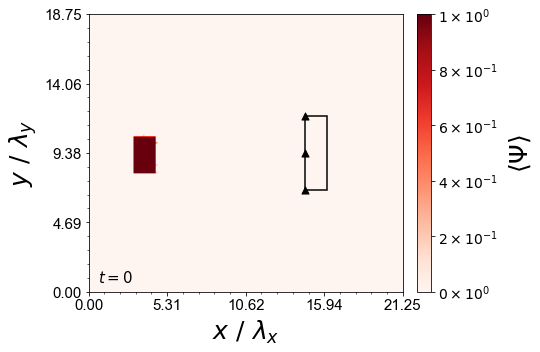

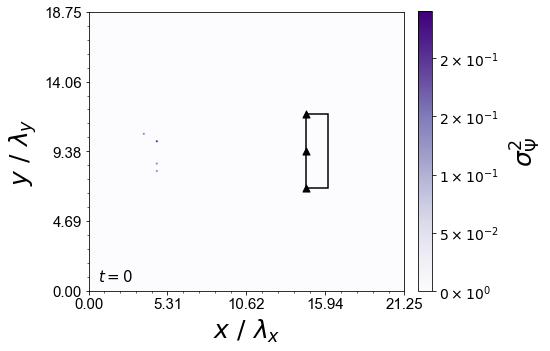

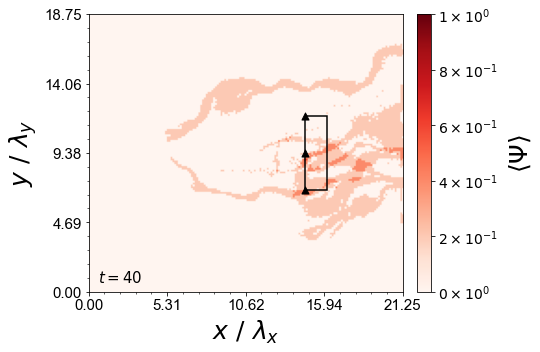

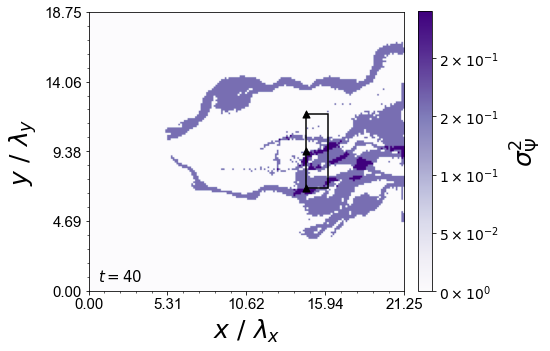

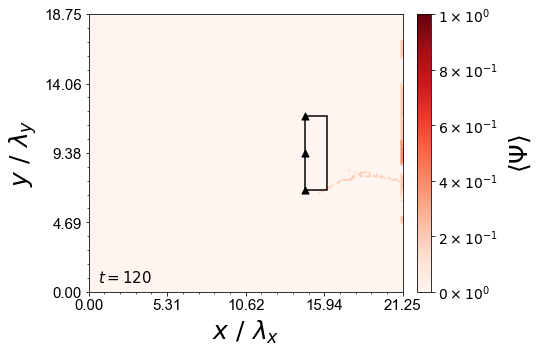

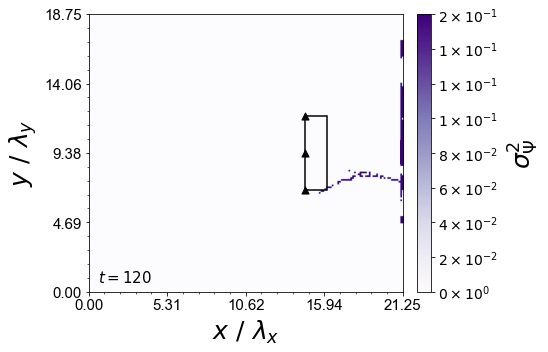

In [43]:
real_n = 'ensemble'
filename = f'riskfield_{real_n}'
time_index = [ 0, 10, 30 ] #  Choose the time steps

# Visualize the map

plotfn.riskfield(filename, real_n, time_index)

#### 6.6b. evaluate how the Aquifer Resilience Loss $R_L$ and its variance $\sigma^2_{R_L}$ changes in  space, base on the whole ensamble results.

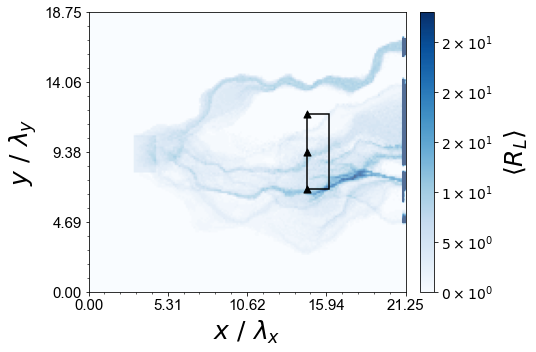

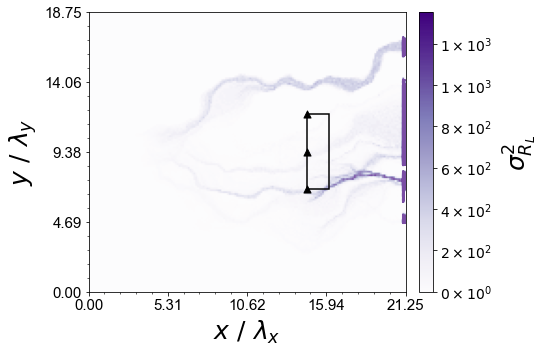

In [44]:
real_n = 'ensemble'
filename = f'resiliencefield_{real_n}'

# Aquifer Resilience Loss: time period exceeding MCL visualize the map

plotfn.resiliencefield(filename, real_n)


### 6.7. The influence of Contaminat Source Efficiency on metrices of contamination risk

#### 6.7a. evaluate the correlation between the Contaminat Source Efficiency $\eta$ and maximum contaminat concentration $C_{MAX}$ and resilience loss $R_L$ experienced at the target zone

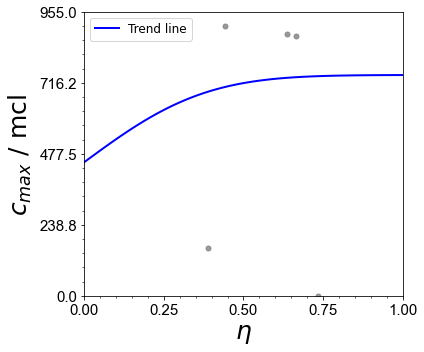

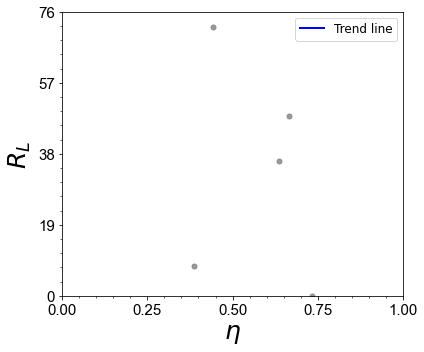

In [45]:
real_n = 'ensemble'

filename = f'eta_rr_{real_n}'

plotfn.eta_rr(filename, real_n)

#### 6.7b. visulize the values realted to a chosen realization and its plume structure at a selected instant in the simulation

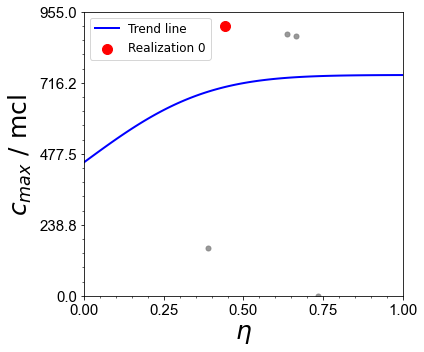

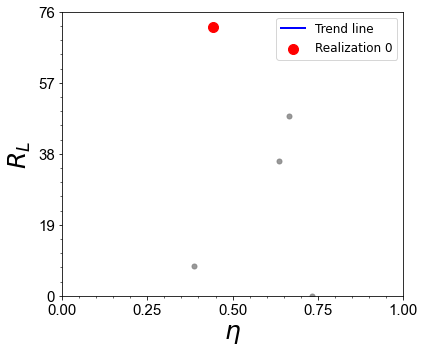

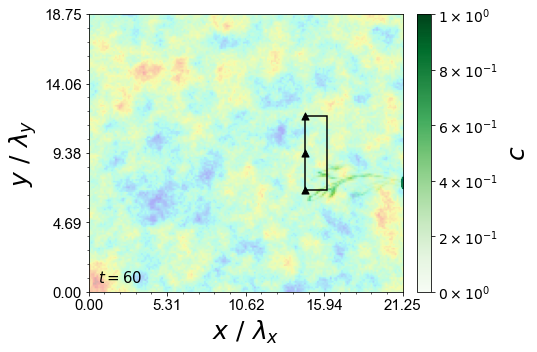

In [46]:
real_n = 0

filename = f'eta_rr_{real_n}'

plotfn.eta_rr(filename, real_n)

# Visualize how the plume is evolving over the Target Area

filename = f'cfield_{real_n}'
time_index = [ 15 ] # examples
plume_edge = False
max_conc = False

plotfn.cfield(filename, real_n, time_index, plume_edge, max_conc)

### 6.8. Target Area Vulnerability: observations wells survival functions $S$  reaspect to the experienced contaminant concentrations at the well to evaluate the probability of exceeding MCL

In [48]:
# survival functions of the defined observation wells 

filename = f'obwells'

plotfn.cdf_maxconc(filename)
